In [1]:
%matplotlib inline

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

import utils

sns.set_context("notebook", font_scale=1.5)
plt.rcParams['figure.figsize'] = (17, 5)

In [2]:
tracks = utils.load('/Users/ajanshul02gmail.com/T-5/Project/Data sets/tracks.csv')
genres = utils.load('/Users/ajanshul02gmail.com/T-5/Project/Data sets/genres.csv')
features = utils.load('/Users/ajanshul02gmail.com/T-5/Project/Data sets/features.csv')
echonest = utils.load('/Users/ajanshul02gmail.com/T-5/Project/Data sets/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [3]:
print('{} tracks, {} artists, {} albums, {} genres'.format(
    len(tracks), len(tracks['artist', 'id'].unique()),
    len(tracks['album', 'id'].unique()),
    sum(genres['#tracks'] > 0)))
mean_duration = tracks['track', 'duration'].mean()
print('track duration: {:.0f} days total, {:.0f} seconds average'.format(
    sum(tracks['track', 'duration']) / 3600 / 24,
    mean_duration))

106574 tracks, 16341 artists, 14854 albums, 161 genres
track duration: 343 days total, 278 seconds average


In [4]:
dimensionality = mean_duration * 44000 * 2
print('sample dimensionality: {:.1e}'.format(dimensionality))
print('total size, i.e. number of audio samples: {:.1e}'.format(dimensionality * len(tracks)))

sample dimensionality: 2.4e+07
total size, i.e. number of audio samples: 2.6e+12


In [5]:
for subset in tracks['set', 'subset'].unique():
    indicator = tracks['set', 'subset'] <= subset
    print('{:6} {:6} tracks  {:.1f} days'.format(
        subset, sum(indicator), sum(indicator) * 30 / 3600 / 24))

small    8000 tracks  2.8 days
medium  25000 tracks  8.7 days
large  106574 tracks  37.0 days


48746 deleted tracks (largest track_id is 155320)
First track: 2008-11-25 17:49:06


/var/folders/w3/y94gskkx7x94zx_nd4z757qw0000gn/T/ipykernel_8791/722254751.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  d['indicator'].resample('2M').sum().fillna(0).plot(ax=ax2, style='--', color=color)


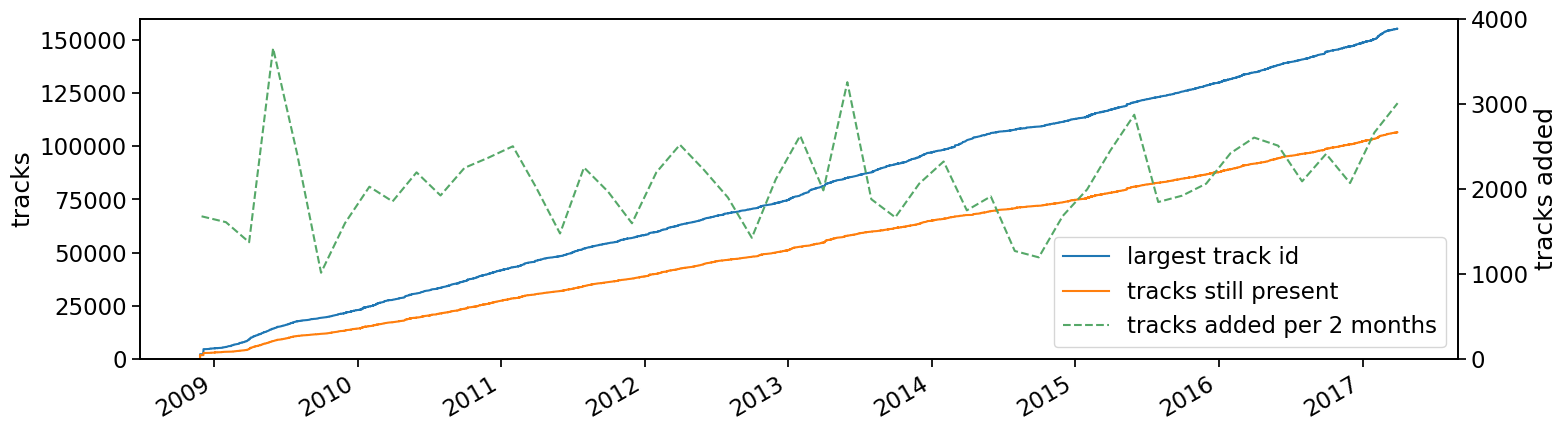

In [8]:
print('{} deleted tracks (largest track_id is {})'.format(tracks.index.max() - len(tracks), tracks.index.max()))
print('First track: {}'.format(tracks['track', 'date_created'].min()))

d = pd.DataFrame(tracks.index, index=tracks['track', 'date_created'].values)
d['indicator'] = 1

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

d['track_id'].plot(ax=ax1)
d['indicator'].cumsum().plot(ax=ax1)
ax1.set_ylabel('tracks')
ax1.set_ylim(0, 160000)

(d['indicator'] * -100).plot(ax=ax2, style='r')  # needed for no apparent reason
color = sns.color_palette('deep', 3)[2]
d['indicator'].resample('2M').sum().fillna(0).plot(ax=ax2, style='--', color=color)
ax2.set_ylabel('tracks added')
ax2.set_ylim(500, 4500)
ax2.set_ylim(0, 4000)
ax2.grid(False)

lns = ax1.get_lines() + [ax2.get_lines()[1]]
ax1.legend(lns, ['largest track id', 'tracks still present', 'tracks added per 2 months'], loc='lower right')

plt.show()

In [15]:
SPLITS = ['training', 'validation', 'test']
SUBSETS = ['small', 'medium', 'large']

print('subset    train    val   test  val_ratio test_ratio')
for subset in SUBSETS:
    counts = [
        sum((tracks['set', 'split'] == split) & (tracks['set', 'subset'] <= subset))
        for split in SPLITS
    ]
    ratios = counts[0] / np.array(counts[1:])
    print('{:8s} {:7d} {:7d} {:7d} {:8.2f} {:9.2f}'.format(subset, *counts, *ratios))

subset    train    val   test  val_ratio test_ratio
small       6400     800     800     8.00      8.00
medium     19922    2505    2573     7.95      7.74
large      84353   10958   11263     7.70      7.49


In [10]:
for subset in ['small', 'medium']:
    subset = tracks['set', 'subset'] <= subset

    d = genres.reset_index().set_index('title')
    d = d.loc[tracks.loc[subset, ('track', 'genre_top')].unique()]

    for split in SPLITS:
        b = tracks['set', 'split'] == split
        d['#' + split] = tracks.loc[subset & b, ('track', 'genre_top')].value_counts()

    d['val_ratio'] = d['#training'] / d['#validation']
    d['test_ratio'] = d['#training'] / d['#test']

    ipd.display(d.sort_values('#training', ascending=False))
     

,genre_id,#tracks,parent,top_level,#training,#validation,#test,val_ratio,test_ratio
title,,,,,,,,,
Hip-Hop,21,8389,0,21,800,100,100,8.0,8.0
Pop,10,13845,0,10,800,100,100,8.0,8.0
Folk,17,12706,0,17,800,100,100,8.0,8.0
Experimental,38,38154,0,38,800,100,100,8.0,8.0
Rock,12,32923,0,12,800,100,100,8.0,8.0
International,2,5271,0,2,800,100,100,8.0,8.0
Electronic,15,34413,0,15,800,100,100,8.0,8.0
Instrumental,1235,14938,0,1235,800,100,100,8.0,8.0


,genre_id,#tracks,parent,top_level,#training,#validation,#test,val_ratio,test_ratio
title,,,,,,,,,
Rock,12,32923,0,12,5681,711,711,7.990155,7.990155
Electronic,15,34413,0,15,5050,632,632,7.990506,7.990506
Experimental,38,38154,0,38,1801,225,225,8.004444,8.004444
Hip-Hop,21,8389,0,21,1761,220,220,8.004545,8.004545
Folk,17,12706,0,17,1215,152,152,7.993421,7.993421
Instrumental,1235,14938,0,1235,1045,131,174,7.977099,6.005747
Pop,10,13845,0,10,945,122,119,7.745902,7.941176
International,2,5271,0,2,814,102,102,7.980392,7.980392
Classical,5,4106,0,5,495,62,62,7.983871,7.983871


In [11]:
d = pd.DataFrame(index=genres.index, columns=SPLITS)
for genre in genres.index:
    b = tracks['track', 'genres_all'].map(lambda genres: genre in genres)
    d.loc[genre] = tracks.loc[b, ('set', 'split')].value_counts()
d['val_ratio'] = d['training'] / d['validation']
d['test_ratio'] = d['training'] / d['test']
d.sort_values('training', ascending=False, inplace=True)
ipd.display(d.head(10))
ipd.display(d.tail(10))

,training,validation,test,val_ratio,test_ratio
genre_id,,,,,
38,29691,4511,3952,6.581911,7.512905
15,27313,3463,3637,7.887092,7.509761
12,25819,3690,3414,6.997019,7.562683
1235,11785,1474,1679,7.995251,7.019059
10,11001,1376,1468,7.994913,7.493869
17,9960,1245,1501,8.0,6.635576
25,7366,974,921,7.562628,7.997828
1,6865,970,858,7.07732,8.001166
21,6426,961,1002,6.686785,6.413174


,training,validation,test,val_ratio,test_ratio
genre_id,,,,,
444,10,7,8,1.428571,1.25
374,9.0,NaN,NaN,NaN,NaN
808,8.0,4.0,NaN,2.0,NaN
465,4,4,10,1.0,0.4
173,3.0,NaN,1.0,NaN,3.0
174,2,1,14,2.0,0.142857
377,1.0,NaN,NaN,NaN,NaN
493,1,1,2,1.0,0.5
175,NaN,NaN,NaN,NaN,NaN


In [18]:
def isnull(column, df=tracks):
    if column[1] in ['tags', 'genres', 'genres_all']:
        # Empty list means missing
        return df[column].apply(lambda x: len(x) == 0)
    elif df.dtypes[column] == int:  # ✅ replaced np.int with int
        # Numeric zeros or negatives treated as missing
        return df[column] <= 0
    else:
        # Standard NaN check
        return df[column].isnull()

# --- Function to count how many entries are non-null ---
def count(series):
    col0 = series.name[0]
    # Use full dataset for tracks, deduplicated per artist/album otherwise
    df = tracks if col0 == 'track' else tracks.drop_duplicates((col0, 'id'))
    
    n = (~isnull(series.name, df)).sum()  # count of non-null
    p = n / len(df) * 100                 # percent coverage
    
    # ✅ Return labeled Series so pandas keeps column names
    return pd.Series({'n': n, 'p': p})

# --- Apply to all metadata columns except 'set' ---
d = pd.DataFrame(index=tracks.columns.drop('set'), columns=['n', 'p'])
d = d.apply(count, axis=1)

# --- Clean up types ---
d['n'] = d['n'].astype(int)

# --- Display results ---
d

n           p
album  comments             1842   12.400700
       date_created        14395   96.909923
       date_released        9450   63.619227
       engineer             2327   15.665814
       favorites            5678   38.225394
       id                  14853   99.993268
       information         11305   76.107446
       listens             14395   96.909923
       producer             2603   17.523899
       tags                 2659   17.900902
       title               14853   99.993268
       tracks              14247   95.913559
       type                13940   93.846775
artist active_year_begin    1254    7.673949
       active_year_end       321    1.964384
       associated_labels     862    5.275075
       bio                  6140   37.574200
       comments             1804   11.039716
       date_created        16109   98.580258
       favorites            7794   47.695979
       id                  16341  100.000000
       latitude             3836   23.474696
       location             6033   36.919405
       longitude            3836   23.474696
       members              4069   24.900557
       name                16341  100.000000
       related_projects      762    4.663117
       tags                15780   96.566918
       website              6945   42.500459
       wikipedia_page        392    2.398874
track  bit_rate           106469   99.901477
       comments             2151    2.018316
       composer             3670    3.443617
       date_created       106574  100.000000
       date_recorded        6159    5.779083
       duration           106558   99.984987
       favorites           64595   60.610468
       genre_top           49598   46.538555
       genres             104343   97.906619
       genres_all         104343   97.906619
       information          2349    2.204102
       interest           106574  100.000000
       language_code       15024   14.097247
       license            106487   99.918367
       listens            106573   99.999062
       lyricist              311    0.291816
       number              98680   92.592940
       publisher            1263    1.185092
       tags                23496   22.046653
       title              106573   99.999062

/var/folders/w3/y94gskkx7x94zx_nd4z757qw0000gn/T/ipykernel_8791/3913606319.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(durations[durations.values < 800], kde=False, rug=False, color='k', hist_kws=dict(alpha=0.4))


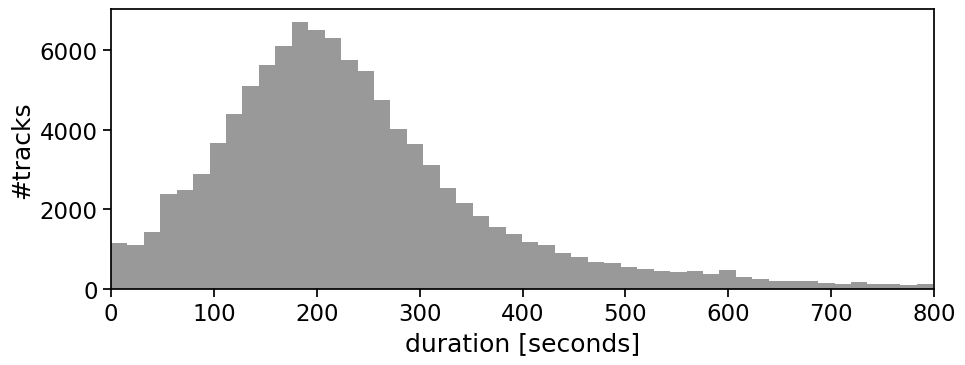

count    106574.000000
mean        277.849100
std         305.518553
min           0.000000
25%         149.000000
50%         216.000000
75%         305.000000
max       18350.000000
Name: (track, duration), dtype: float64

In [19]:
durations = tracks['track', 'duration']
plt.figure(figsize=(10, 4))  # Poster: (7, 3)
p = sns.distplot(durations[durations.values < 800], kde=False, rug=False, color='k', hist_kws=dict(alpha=0.4))
p.set_xlabel('duration [seconds]')
p.set_ylabel('tracks')
p.set_xlim(0, 800)  # Poster: 500
plt.tight_layout()
plt.show()

durations.describe()

Common bit rates: [320000, 256000, 192000, 128000, 160000]
Average bit rate: 263 kbit/s


/var/folders/w3/y94gskkx7x94zx_nd4z757qw0000gn/T/ipykernel_8791/2019078663.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(tracks['track', 'bit_rate'], kde=False, rug=False)


Text(0, 0.5, 'tracks')

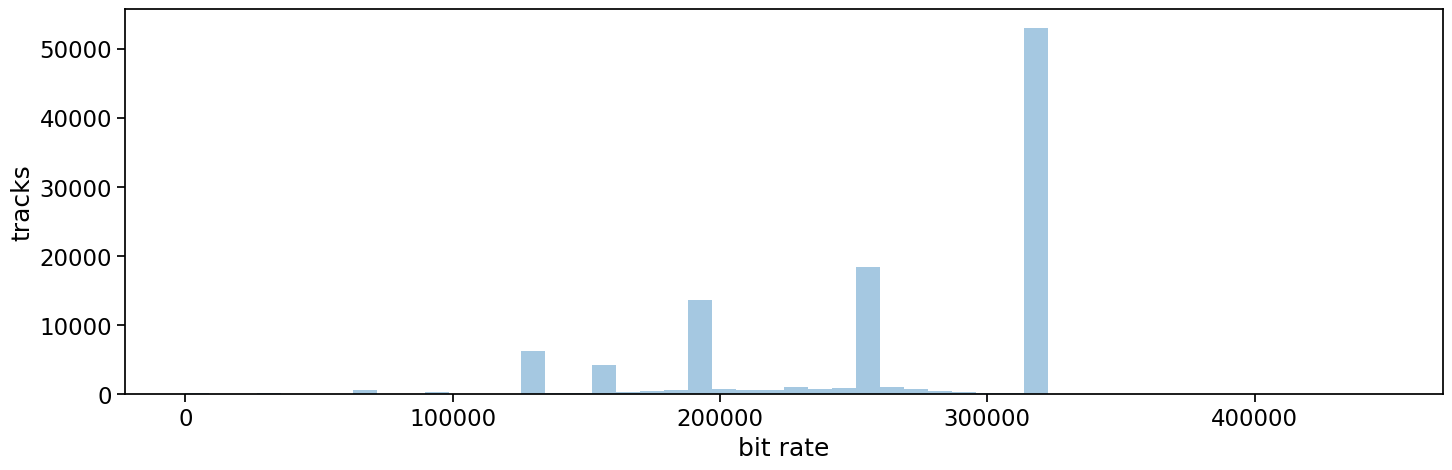

In [21]:
print('Common bit rates: {}'.format(tracks['track', 'bit_rate'].value_counts().head(5).index.tolist()))
print('Average bit rate: {:.0f} kbit/s'.format(tracks['track', 'bit_rate'].mean()/1000))
p = sns.distplot(tracks['track', 'bit_rate'], kde=False, rug=False)
p.set_xlabel('bit rate')
p.set_ylabel('tracks')

track: from 0 to 150 tags
album: from 0 to 150 tags
artist: from 0 to 55 tags


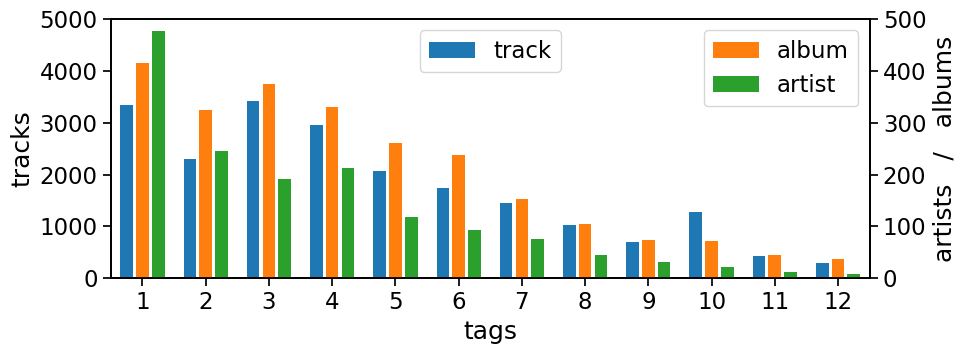

In [24]:
d1 = tracks['track', 'tags'].apply(len)
d2 = tracks.drop_duplicates(('album', 'id'))
d2 = d2['album', 'tags'].apply(len)
d3 = tracks.drop_duplicates(('artist', 'id'))
d3 = d3['artist', 'tags'].apply(len) - 1

labels = ['track', 'album', 'artist']
for l, d in zip(labels, [d1, d2, d3]):
    print('{}: from {} to {} tags'.format(l, max(d.min(), 0), d.max()))

MAX = 13  # Poster: 11
fig, ax1 = plt.subplots(figsize=(10, 4))  # Poster: (7, 3)
ax2 = ax1.twinx()

ax1.hist(d1, bins=np.arange(MAX)+0.25, rwidth=0.2, color='C0', label=labels[0])
ax2.hist(d2, bins=np.arange(MAX)+0.50, rwidth=0.2, color='C1', label=labels[1])
ax2.hist(d3, bins=np.arange(MAX)+0.75, rwidth=0.2, color='C2', label=labels[2])

ax1.set_xlabel('tags')
ax1.set_ylabel('tracks')
ax2.set_ylabel('artists   /   albums')
ax1.set_xlim(0.5, MAX-0.5)
ax1.set_xticks(range(1, MAX))
ax1.set_ylim(0, 5000)
ax2.set_ylim(0, 500)
ax1.legend(loc='upper center')
ax2.legend(loc='upper right')
ax2.grid(False)

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [28]:
a = set(tracks['track', 'genre_top'].unique().dropna())
b = set(genres.loc[genres['top_level'].unique(), 'title'].values)
assert a == b

print('{} top-level genres'.format(len(a)))
genres[genres['parent'] == 0].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4
